### Neural network

In [1]:
import tensorflow as tf
import numpy as np
import os
from astropy.io import fits 
from astropy import stats
from scipy.ndimage import rotate
import matplotlib.pyplot as plt

C:\Users\JakeM\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
def get_clipped_images(filepath,xpix,ypix,sigma):
    '''
    Put FITS data from desired folder into a 3D array
    sigma = how many sigmas from the median background value to sigma clip the data to
    
    TODO: Need to check for .fits ending so works if other files in directory
    '''
    newpath = filepath.replace(os.sep, '/')
    dirs = os.listdir(newpath)
    n = len(dirs)
    data = np.empty(shape=(n,xpix,ypix),dtype=np.float64)
    for i in range(n):
        fullpath = '{}/{}'.format(newpath,dirs[i])
        d = fits.getdata(fullpath, ext=0)
        d[np.isnan(d)] = 0
        _,median,std = stats.sigma_clipped_stats(d, sigma=sigma)
        d[d<median+sigma*std] = median+sigma*std
        data[i,:,:] = d
        #if i%100==0:
            #print(i)
    return data

def augment_data(data,size,xpix,ypix):
    '''
    Augment the data (3D array of images) by flipping and rotating the images.
    Size = upper bound on the final number of images 
    (actual_size can be much less depending on size/data_size multiples)
    
    TODO: Make the actual size = size
    Make sure still works if size<len(data)
    '''
    rotations = size//len(data) # rotations per image
    angles = np.linspace(0, 360, rotations)
    act_size = rotations*len(data)
    training_set = np.empty((act_size, xpix, ypix))
    for i in range(len(data)):
        for j in range(len(angles)):
            if j % 2 == 0: training_set[i*len(angles)+j,:,:] = rotate(np.fliplr(data[i,:,:]), angles[j], reshape=False)
            else: training_set[i*len(angles)+j,:,:] = rotate(data[i,:,:], angles[j], reshape=False)
    return training_set

def train_test(data,percentage):
    '''
    Combines data sets in one 3D array, with a different label for each data set.
    Then randomly shuffles the data and splits into training and test sets.
    data = list of 3D arrays containing desired data sets
    per = fraction of data to be in training set
    returns: train and test data (each a tupple containing the data and corresponding labels)
    '''
    d = np.concatenate(data,axis=0)
    n_images = len(d)
    labels = np.empty(n_images)
    i = 0
    for n in range(len(data)):
        labels[i:i+len(data[n])] = n
        i += len(data[n])
    rand_ind = np.random.permutation(range(n_images))
    d, labels = d[rand_ind], labels[rand_ind]
    n_train = np.int(np.round(n_images*percentage))
    train = (d[:n_train], labels[:n_train])
    test = (d[n_train:], labels[n_train:])
    return train, test

In [5]:
# Number of x pixels and y pixels in each image (must be the same for all images)
xpix, ypix = 83, 83

# Directories with the FITS data
agn_path = r'C:\Users\JakeM\Google Drive\University of Birmingham\Year 4\Project\5. Code\Data\FITS agn'
ps_path = r'C:\Users\JakeM\Google Drive\University of Birmingham\Year 4\Project\5. Code\Data\FITS stars'

# Get FITs images and augment data sets
agn_data = get_clipped_images(agn_path,xpix,ypix,sigma=3)

In [5]:
#np.save('agn_data', agn_data)

In [71]:
ps_data = get_clipped_images(ps_path,xpix,ypix,sigma=1)
agn_augment = augment_data(agn_data,10000,xpix,ypix)
ps_augment = augment_data(ps_data,10000,xpix,ypix)

data = (agn_augment, ps_augment) # list of all data sets to be used

In [72]:
train, test = train_test(data,0.2) # training and test data, each in a tuple with data label array

In [73]:
# Neural network
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(xpix, ypix)),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)])
    
# Compile the network
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [74]:
# Perform fit
model.fit(*train, epochs=10)
test_loss, test_acc = model.evaluate(*test, verbose=2)
print('\nTest accuracy:', test_acc)

Train on 3483 samples
Epoch 1/10
3483/3483 [==============================] - 6s 2ms/sample - loss: 0.7933 - accuracy: 0.8200
Epoch 2/10
3483/3483 [==============================] - 3s 872us/sample - loss: 0.0433 - accuracy: 1.0000
Epoch 3/10
3483/3483 [==============================] - 3s 845us/sample - loss: 0.0118 - accuracy: 1.0000
Epoch 4/10
3483/3483 [==============================] - 3s 883us/sample - loss: 0.0058 - accuracy: 1.0000
Epoch 5/10
3483/3483 [==============================] - 3s 876us/sample - loss: 0.0037 - accuracy: 1.0000
Epoch 6/10
3483/3483 [==============================] - 3s 881us/sample - loss: 0.0024 - accuracy: 1.0000
Epoch 7/10
3483/3483 [==============================] - 3s 891us/sample - loss: 0.0018 - accuracy: 1.0000
Epoch 8/10
3483/3483 [==============================] - 3s 895us/sample - loss: 0.0014 - accuracy: 1.0000
Epoch 9/10
3483/3483 [==============================] - 3s 922us/sample - loss: 0.0011 - accuracy: 1.0000
Epoch 10/10
3483/3483 [===

Above shows can achieve 100% accruacy between point sources and AGN even with a simple neural net.

### Classifying AGN with jet angle

In [6]:
# Plot histogram of the angles of the AGN, using data given in VizieR data catalog
# Need to get txt file with the angle in it, similar to RA and Dec txt file

import pandas as pd

path = r'C:\Users\JakeM\Google Drive\University of Birmingham\Year 4\Project\5. Code\Data\agn bending angle.txt'
agn_ang = np.array(pd.read_csv(path, sep='\s+', header=None, usecols=[2])) # bending angle of agn, from vizier catalog
len(agn_ang), len(agn_data)

# Not the same length since some coords couldn't be downloaded... 'out of range of survey'
# Need to be the same length for labelling...
# So compare GaronAGN2019_RA_dec.txt coords with filename or coords in fits file to find which are missing
# Or use download form...

(3723, 3712)

In [7]:
# Have to use RA in degrees (i.e. decimal) for correct comparison and rounding

path = r'C:\Users\JakeM\Google Drive\University of Birmingham\Year 4\Project\5. Code\Data\GaronAGN2019_RA_dec.txt'
agn_ra = np.squeeze(np.array(pd.read_csv(path, sep='\s+', header=None, usecols=[1])))
agn_ra = np.around(agn_ra, 5)

directory_path = r'C:\Users\JakeM\Google Drive\University of Birmingham\Year 4\Project\5. Code\Data\FITS agn'
files = [f for f in os.listdir(directory_path) if f.endswith('.fits')]

files_ra = np.empty(len(files))
for i in range(len(files)):
    file_path = directory_path + '\\' + files[i]
    ra = fits.getval(file_path, 'OBJCTRA')
    hours, mins, secs = int(ra[:2]), int(ra[3:5]), float(ra[6:12])
    ra_deg = (hours+mins/60+secs/3600)*(360/24) # convert RA from hh:mm:ss to degrees
    ra_deg = round(ra_deg, 5)
    files_ra[i] = ra_deg
    
missing_i = np.squeeze([np.argwhere(agn_ra==ra) for ra in agn_ra if ra not in files_ra])

In [8]:
agn_ang = np.delete(agn_ang, missing_i)
len(agn_ang), len(agn_data)

(3712, 3712)

In [9]:
#np.save('agn_ang', agn_ang)

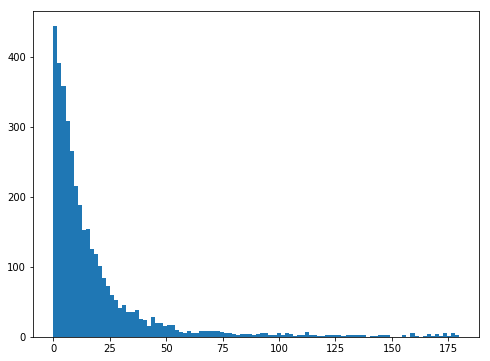

In [10]:
plt.figure(figsize=(8,6))
plt.hist(agn_ang, bins = 100, rwidth = 1)
plt.show()

In [89]:
# Define angle ranges for three different categories of AGN (choose limits to split data in thirds??)
ang1 = 20
ang2 = 45

# Assign each image in agn_data a label depending on which angle range it is in
labels = np.empty(len(agn_data))
for i in range(len(agn_ang)):
    if agn_ang[i] < ang1: labels[i] = 1
    elif agn_ang[i] > ang2: labels[i] = 3
    else: labels[i] = 2

# Could achieve this in the above way with the original agn_data array retained, or seperate into 3 arrays for each cat.
# Need to augment the data and have a label array for the augmented array.
# Easy to achieve using defined functions if split into 3 arrays
# This would also allow augmenting of each category individually which has benefits.

# Was thinking could be more efficient to keep in array and augment along with labels
# This would mean no need to concatenate the arrays of each data set / category...

In [90]:
cat1 = agn_data[labels==1]
cat2 = agn_data[labels==2]
cat3 = agn_data[labels==3]

In [91]:
# Augment the data
data = [] # empty list
for cat in (cat1,cat2,cat3):
    data.append(augment_data(cat,10000,xpix,ypix))

In [92]:
# Get training and test data and labels
train, test = train_test(data, 0.8)

In [93]:
# Neural network
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(xpix, ypix)),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)])
    
# Compile the network
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [94]:
# Perform fit
model.fit(*train, epochs=10)
test_loss, test_acc = model.evaluate(*test, verbose=2)
print('\nTest accuracy:', test_acc)

Train on 22334 samples
Epoch 1/10
22334/22334 [==============================] - 22s 989us/sample - loss: 0.8556 - accuracy: 0.5868
Epoch 2/10
22334/22334 [==============================] - 21s 921us/sample - loss: 0.6980 - accuracy: 0.6581
Epoch 3/10
22334/22334 [==============================] - 21s 922us/sample - loss: 0.6549 - accuracy: 0.7103
Epoch 4/10
22334/22334 [==============================] - 21s 924us/sample - loss: 0.5989 - accuracy: 0.7710
Epoch 5/10
22334/22334 [==============================] - 21s 922us/sample - loss: 0.5389 - accuracy: 0.8153
Epoch 6/10
22334/22334 [==============================] - 21s 919us/sample - loss: 0.4809 - accuracy: 0.8465
Epoch 7/10
22334/22334 [==============================] - 21s 934us/sample - loss: 0.4339 - accuracy: 0.8625- loss: 0.4350 - 
Epoch 8/10
22334/22334 [==============================] - 21s 918us/sample - loss: 0.3965 - accuracy: 0.8727
Epoch 9/10
22334/22334 [==============================] - 21s 919us/sample - loss: 0.369